<a href="https://colab.research.google.com/github/Sangh0/Classification/blob/main/alexnet_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet Practice  

## Step 1. Import packages and modules

In [1]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.models as models
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsummary import summary

In [2]:
SEED = 42

def RANDOM_SEED(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

RANDOM_SEED(SEED)

## Step 2. Set hyperparameters

In [3]:
Config = {
    'batch_size': 128,
    'lr': 0.01,
    'epochs': 90,
    'weight_decay': 5e-4,
    'momentum': 0.9,
}

## Step 3. Load Dataset

In [4]:
# augmentation
train_transforms_ = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

valid_transforms_ = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load CIFAR-10 
# train: 50000 (5000 per class), test: 10000 (1000 per class)
train_data = dset.CIFAR10(
    root='./cifar10', 
    train=True, 
    download=True, 
    transform=train_transforms_,
)

test_data = dset.CIFAR10(
    root='./cifar10',
    train=False,
    download=True,
    transform=valid_transforms_,
)

# stratify split (train: 80%, valid: 20%)
train_index, valid_index = train_test_split(
    np.arange(len(train_data)),
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
    stratify=train_data.targets,
)

# define data loaders for batch learning
train_loader = DataLoader(
    train_data,
    batch_size=Config['batch_size'],
    sampler=SubsetRandomSampler(train_index),
    drop_last=True,
    num_workers=int(cpu_count()/2),
)

valid_loader = DataLoader(
    train_data,
    batch_size=Config['batch_size'],
    sampler=SubsetRandomSampler(valid_index),
    drop_last=True,
    num_workers=int(cpu_count()/2),
)

test_loader = DataLoader(
    test_data,
    batch_size=Config['batch_size'],
    shuffle=False,
    drop_last=False,
    num_workers=int(cpu_count()/2),
)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


## Step 4-1. Build Model (Random Weights) 


In [5]:
class AlexNet(nn.Module):
    
    def __init__(
        self,
        in_dim=3,
        filters=[96, 256, 384, 384, 256],
        dropout=0.5,
        num_classes=1000,
    ):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_dim, filters[0], kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(filters[0], filters[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            
            nn.Conv2d(filters[1], filters[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(filters[2], filters[3], kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(filters[3], filters[4], kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(filters[4]*6*6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
      
            nn.Linear(4096, num_classes),
        )

        self._init_weights_()
        
    def forward(self, x):
        B = x.size(0)
        x = self.features(x)
        x = x.view(B, -1)
        x = self.classifier(x)
        return x

    def _init_weights_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 1)
        
        nn.init.constant_(self.features[0].bias, 0)
        nn.init.constant_(self.features[8].bias, 0)

## Step 4-2. Build Model (pre-trained weights)

In [6]:
class AlexNet(nn.Module):

    def __init__(
        self,
        dropout=None,
        num_classes=1000,
        del_conv=False,
        init_weights=False,
    ):
        super().__init__()

        self.model = models.alexnet(pretrained=True)

        if del_conv:
            del self.model.features[8]
            del self.model.features[9]
            self.model.features[10] = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        if dropout is not None:
            self.model.classifier[0] = nn.Dropout(p=dropout, inplace=False)
            self.model.classifier[3] = nn.Dropout(p=dropout, inplace=False)
            
        self.model.classifier[-1] = nn.Linear(4096, num_classes)

        if init_weights:
            self._init_weights_()

    def forward(self, x):
        return self.model(x)

    def _init_weights_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 1)
        
        nn.init.constant_(self.features[0].bias, 0)
        nn.init.constant_(self.features[8].bias, 0)


# Step 5. Set Callbacks

In [7]:
class EarlyStopping(object):
    
    def __init__(
        self, 
        patience=7, 
        verbose=False, 
        delta=0, 
        path='es_checkpoint.pt', 
        trace_func=print,
    ):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_model(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'\nEarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_model(val_loss, model)
            self.counter = 0
            
    def save_model(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'\nValidation loss decreased ({self.val_loss_min:.3f} --> {val_loss:.3f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Step 6. Train Model

In [8]:
class TrainModel(object):
    
    def __init__(
        self,
        model,
        lr=Config['lr'],
        epochs=Config['epochs'],
        weight_decay=Config['weight_decay'],
        lr_scheduling=True,
        check_point=True,
        early_stop=False,
        es_path=None,
        train_log_step=10,
        valid_log_step=5,
    ):
        assert (early_stop==True and es_path is not None) or \
            (early_stop==False and es_path is None), \
            'If you set early stop, then es_path must be not None'

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        ######### Multi GPU training #########
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = nn.DataParallel(model)
            self.model = model.to(self.device)
        ######################################

        ######### Single GPU training #########
        else:
            print('Single GPU training!')
            self.model = model.to(self.device)
        #######################################

        self.loss_func = nn.CrossEntropyLoss().to(self.device)
        
        self.epochs = epochs
        
        self.optimizer = optim.SGD(
            self.model.parameters(),
            momentum=Config['momentum'],
            lr=lr,
            weight_decay=weight_decay,
        )

        self.lr_scheduling = lr_scheduling
        self.lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.1,
            patience=10,
            verbose=True,
            min_lr=lr*1e-2,
        )

        os.makedirs('./weights', exist_ok=True)
        es_path = './weights/'+es_path if es_path is not None else './weights/es_weight.pt'
        self.early_stop = early_stop
        self.es = EarlyStopping(patience=15, verbose=True, path=es_path)
        
        self.train_log_step = train_log_step
        self.valid_log_step = valid_log_step
        
    def fit(self, train_data, validation_data):
        print('Start Model Training...!')
        loss_list, acc_list = [], []
        val_loss_list, val_acc_list = [], []
        start_training = time.time()
        pbar = tqdm(range(self.epochs), total=int(self.epochs))
        for epoch in pbar:
            init_time = time.time()
            
            ######### Train Phase #########
            train_loss, train_acc = self.train_on_batch(
                train_data, self.train_log_step,
            )

            loss_list.append(train_loss)
            acc_list.append(train_acc)

            ######### Validate Phase #########
            valid_loss, valid_acc = self.validate_on_batch(
                validation_data, self.valid_log_step,
            )

            val_loss_list.append(valid_loss)
            val_acc_list.append(valid_acc)

            end_time = time.time()
            
            print(f'\n{"="*30} Epoch {epoch+1}/{self.epochs} {"="*30}'
                  f'\ntime: {end_time-init_time:.2f}s'
                  f'   lr = {self.optimizer.param_groups[0]["lr"]}')
            print(f'\ntrain average loss: {train_loss:.3f}'
                  f'  accuracy: {train_acc:.3f}')
            print(f'\nvalid average loss: {valid_loss:.3f}'
                  f'  accuracy: {valid_acc:.3f}')
            print(f'\n{"="*76}')
            
            if self.lr_scheduling:
                self.lr_scheduler.step(valid_loss)

            if self.early_stop:
                self.es(valid_loss, self.model)
                if self.es.early_stop:
                    print('\n##########################\n'
                          '##### Early Stopping #####\n'
                          '##########################')
                    break

        end_training = time.time()
        print(f'\nTotal time for training is {end_training-start_training:.2}s')
        
        return {
            'model': self.model,
            'loss': loss_list,
            'acc': acc_list,
            'val_loss': val_loss_list,
            'val_acc': val_acc_list,
        }
        
    @torch.no_grad()
    def validate_on_batch(self, validation_data, log_step):
        self.model.eval()
        batch_loss, batch_acc = 0, 0
        for batch, (images, labels) in enumerate(validation_data):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            outputs = self.model(images)
            loss = self.loss_func(outputs, labels)
            output_index = torch.argmax(outputs, dim=1)
            acc = (output_index==labels).sum()/len(outputs)
            
            if batch == 0:
                print(f'\n{" "*10} Validate Step {" "*10}')
                
            if (batch+1) % log_step == 0:
                print(f'\n[Batch {batch+1}/{len(validation_data)}]'
                      f'  valid loss: {loss:.3f}  accuracy: {acc:.3f}')
                
            batch_loss += loss.item()
            batch_acc += acc.item()
            
            del images; del labels; del outputs
            torch.cuda.empty_cache()
            
        return batch_loss/(batch+1), batch_acc/(batch+1)
        
    def train_on_batch(self, train_data, log_step):
        self.model.train()
        batch_loss, batch_acc = 0, 0
        for batch, (images, labels) in enumerate(train_data):
            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(images)
            loss = self.loss_func(outputs, labels)
            output_index = torch.argmax(outputs, dim=1)
            acc = (output_index==labels).sum()/len(outputs)
            
            loss.backward()
            self.optimizer.step()
            
            
            if batch == 0:
                print(f'\n{" "*10} Train Step {" "*10}')
                
            if (batch+1) % log_step == 0:
                print(f'\n[Batch {batch+1}/{len(train_data)}]'
                      f'  train loss: {loss:.3f}  accuracy: {acc:.3f}')
                
            batch_loss += loss.item()
            batch_acc += acc.item()
            
            del images; del labels; del outputs
            torch.cuda.empty_cache()
        
        return batch_loss/(batch+1), batch_acc/(batch+1)

In [9]:
# case 4: epoch 150 with learning rate 1e-4
epoch150_lower_lr_alexnet = AlexNet(num_classes=10)
summary(epoch150_lower_lr_alexnet, (3, 224, 224), device='cpu')

case3_model = TrainModel(
    model=epoch150_lower_lr_alexnet,
    lr=1e-4,
    epochs=150,
    train_log_step=1000,
    valid_log_step=300,
    early_stop=True,
    es_path='epoch150_lr1e-4.pt',
)

history3 = case3_model.fit(train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

  0%|          | 0/150 [00:00<?, ?it/s]


           Train Step           

           Validate Step           

============================== Epoch 1/150 ==============================
time: 79.05s   lr = 0.0001

train average loss: 1.220  accuracy: 0.582

valid average loss: 0.750  accuracy: 0.743


Validation loss decreased (inf --> 0.750).  Saving model ...

           Train Step           

           Validate Step           

============================== Epoch 2/150 ==============================
time: 96.56s   lr = 0.0001

train average loss: 0.742  accuracy: 0.741

valid average loss: 0.627  accuracy: 0.781


Validation loss decreased (0.750 --> 0.627).  Saving model ...

           Train Step           

           Validate Step           

============================== Epoch 3/150 ==============================
time: 103.09s   lr = 0.0001

train average loss: 0.652  accuracy: 0.772

valid average loss: 0.558  accuracy: 0.810


Validation loss decreased (0.627 --> 0.558).  Saving model ...

           Train Step 

In [10]:
# case 5: dropout rate 0.1
dropout01_alexnet = AlexNet(num_classes=10, dropout=0.1)
summary(dropout01_alexnet, (3, 224, 224), device='cpu')

case1_model = TrainModel(
    model=dropout01_alexnet,
    lr=1e-2,
    epochs=90,
    train_log_step=1000,
    valid_log_step=300,
    early_stop=True,
    es_path='dropout01_alexnet.pt',
)

history1 = case1_model.fit(train_loader, valid_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

  0%|          | 0/90 [00:00<?, ?it/s]


           Train Step           

           Validate Step           

============================== Epoch 1/90 ==============================
time: 82.93s   lr = 0.01

train average loss: 0.760  accuracy: 0.736

valid average loss: 0.576  accuracy: 0.798


Validation loss decreased (inf --> 0.576).  Saving model ...

           Train Step           

           Validate Step           

============================== Epoch 2/90 ==============================
time: 82.20s   lr = 0.01

train average loss: 0.464  accuracy: 0.839

valid average loss: 0.487  accuracy: 0.832


Validation loss decreased (0.576 --> 0.487).  Saving model ...

           Train Step           

           Validate Step           

============================== Epoch 3/90 ==============================
time: 83.11s   lr = 0.01

train average loss: 0.363  accuracy: 0.874

valid average loss: 0.427  accuracy: 0.852


Validation loss decreased (0.487 --> 0.427).  Saving model ...

           Train Step           

In [11]:
# case 6: remove one convolution layer
del_conv_alexnet = AlexNet(num_classes=10)
summary(del_conv_alexnet, (3, 224, 224), device='cpu')

case2_model = TrainModel(
    model=del_conv_alexnet,
    lr=1e-2,
    epochs=90,
    train_log_step=1000,
    valid_log_step=300,
    early_stop=True,
    es_path='del_conv_alexnet.pt'
)

history2 = case2_model.fit(train_loader, valid_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

  0%|          | 0/90 [00:00<?, ?it/s]


           Train Step           

           Validate Step           

============================== Epoch 1/90 ==============================
time: 103.06s   lr = 0.01

train average loss: 0.831  accuracy: 0.710

valid average loss: 0.557  accuracy: 0.808


Validation loss decreased (inf --> 0.557).  Saving model ...

           Train Step           

           Validate Step           

============================== Epoch 2/90 ==============================
time: 102.69s   lr = 0.01

train average loss: 0.545  accuracy: 0.812

valid average loss: 0.498  accuracy: 0.823


Validation loss decreased (0.557 --> 0.498).  Saving model ...

           Train Step           

           Validate Step           

============================== Epoch 3/90 ==============================
time: 101.65s   lr = 0.01

train average loss: 0.465  accuracy: 0.838

valid average loss: 0.426  accuracy: 0.852


Validation loss decreased (0.498 --> 0.426).  Saving model ...

           Train Step        

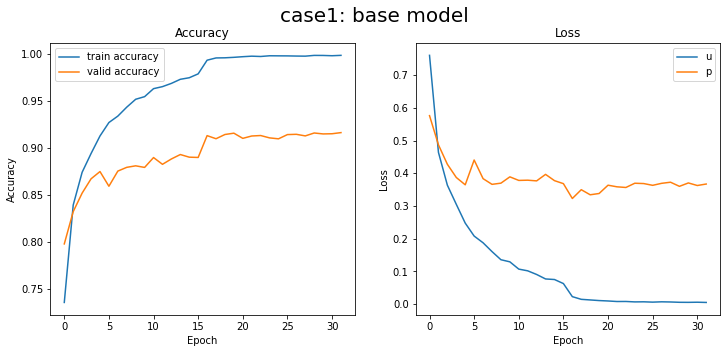

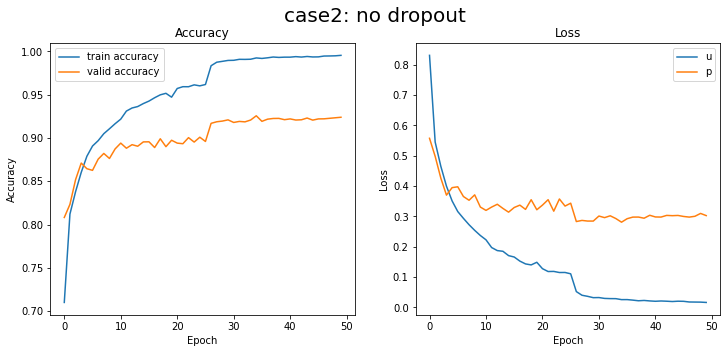

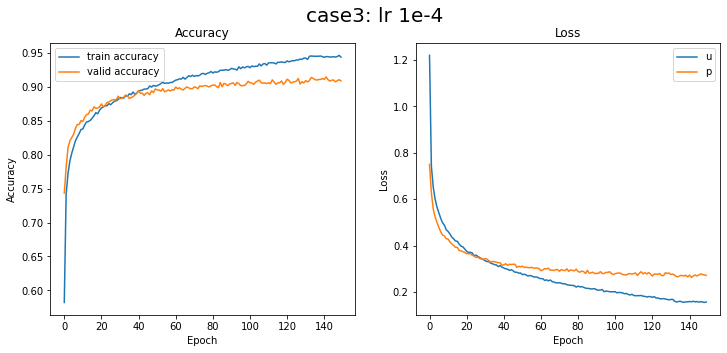

In [12]:
def show_graphs(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, size=20)
    ax[0].plot(history['acc'], label='train accuracy')
    ax[0].plot(history['val_acc'], label='valid accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='upper left')
    
    ax[1].plot(history['loss'], label='train loss')
    ax[1].plot(history['val_loss'], label='valid loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend('upper left')

    plt.show()


title_list = ['case4: epoch 150 with lr 1e-4', 'case2: dropout rate 0.1', 'case3: remove conv layer']
historys = [history1, history2, history3]

for n in range(len(title_list)):
    show_graphs(historys[n], title_list[n])

## Step 7. Evaluate performance of model

In [13]:
@torch.no_grad()
def eval(model, dataset, loss_func=nn.CrossEntropyLoss()):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)

    model.eval() 
    batch_loss, batch_acc = 0, 0
    pbar = tqdm(enumerate(dataset), total=len(dataset))
    
    start = time.time()
    for batch, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)
    
        outputs = model(images)
        loss = loss_func(outputs, labels)
        output_index = torch.argmax(outputs, dim=1)
        acc = (output_index==labels).sum()/len(outputs)

        batch_loss += loss.item()
        batch_acc += acc.item()

        del images; del labels; del outputs
        torch.cuda.empty_cache()

    end = time.time()

    print(f'\nTotal time for testing is {end-start:.2f}s')
    print(f'\nAverage loss: {batch_loss/(batch+1):.3f}  accuracy: {batch_acc/(batch+1):.3f}')

    return {
        'loss': batch_loss/(batch+1),
        'accuracy': batch_acc/(batch+1),
    }

In [14]:
result1 = eval(history1['model'], test_loader)
result2 = eval(history2['model'], test_loader)
result3 = eval(history3['model'], test_loader)

  0%|          | 0/79 [00:00<?, ?it/s]


Total time for testing is 14.39s

Average loss: 0.372  accuracy: 0.920


  0%|          | 0/79 [00:00<?, ?it/s]


Total time for testing is 14.76s

Average loss: 0.304  accuracy: 0.927


  0%|          | 0/79 [00:00<?, ?it/s]


Total time for testing is 15.00s

Average loss: 0.260  accuracy: 0.918
